<a href="https://colab.research.google.com/github/nimnathw/energy-consumption/blob/main/energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### We are using a time-series dataset from the UCI database. Target is the energy consmuption of a single house. The features set includes weather data and household sensor data overtime.

* Steps followed.
1. Load data
2. Check a sample of rows
3. Check for missing values
4. Check for outliers
5. Clean data
6. Remove unncessary columns
7. Create binary variables for non-ordinal variables
8. Visualize data (check for outliers)
9. Visualize correlation (check for multi-colinearity)
10. Quantify multicollinearity with VIF
11. Standardize data (and transform if necessary)
12. Split dataset to train, validation and test sets
13. Run OLS  and evaluate perfomance metrics and robustness of underlying assumptions
14. Use first differencing and rerun model (to address non-stationary data and/or auto-correlation)
15. Conduct PCA (and re-run the regression) if there is high multicollinearity
Run Arima model
16. Run Random Forest model and evaluate performance metrics
17. Select the final model and run the model on the test set
18. Evaluate performance metrics and model robustness
19. Conduct sensitivity analysis
20. Interpret results

In [32]:
# Import libraries

import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

file = '/content/drive/MyDrive/Colab Notebooks/energydata_complete.csv'

df = pd.read_csv(file)
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [2]:
# Show the list of columns
print(df.columns)

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')


In [3]:
# Check for missing values
print(df.isnull().sum(axis=0))

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


In [4]:
# Check for data types of columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [5]:
# Convert string to datetime object
df_processed = df
df_processed["time"] = df_processed["date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_processed = df_processed.drop("date", axis=1)

# Convert datetime object to integer
df_processed["time"] = df_processed["time"].apply(lambda x: int(x.timestamp()))


# Print the processed dataframe
print(df_processed)

       Appliances  lights         T1       RH_1         T2       RH_2  \
0              60      30  19.890000  47.596667  19.200000  44.790000   
1              60      30  19.890000  46.693333  19.200000  44.722500   
2              50      30  19.890000  46.300000  19.200000  44.626667   
3              50      40  19.890000  46.066667  19.200000  44.590000   
4              60      40  19.890000  46.333333  19.200000  44.530000   
...           ...     ...        ...        ...        ...        ...   
19730         100       0  25.566667  46.560000  25.890000  42.025714   
19731          90       0  25.500000  46.500000  25.754000  42.080000   
19732         270      10  25.500000  46.596667  25.628571  42.768571   
19733         420      10  25.500000  46.990000  25.414000  43.036000   
19734         430      10  25.500000  46.600000  25.264286  42.971429   

              T3       RH_3         T4       RH_4  ...     RH_9      T_out  \
0      19.790000  44.730000  19.000000  45.56

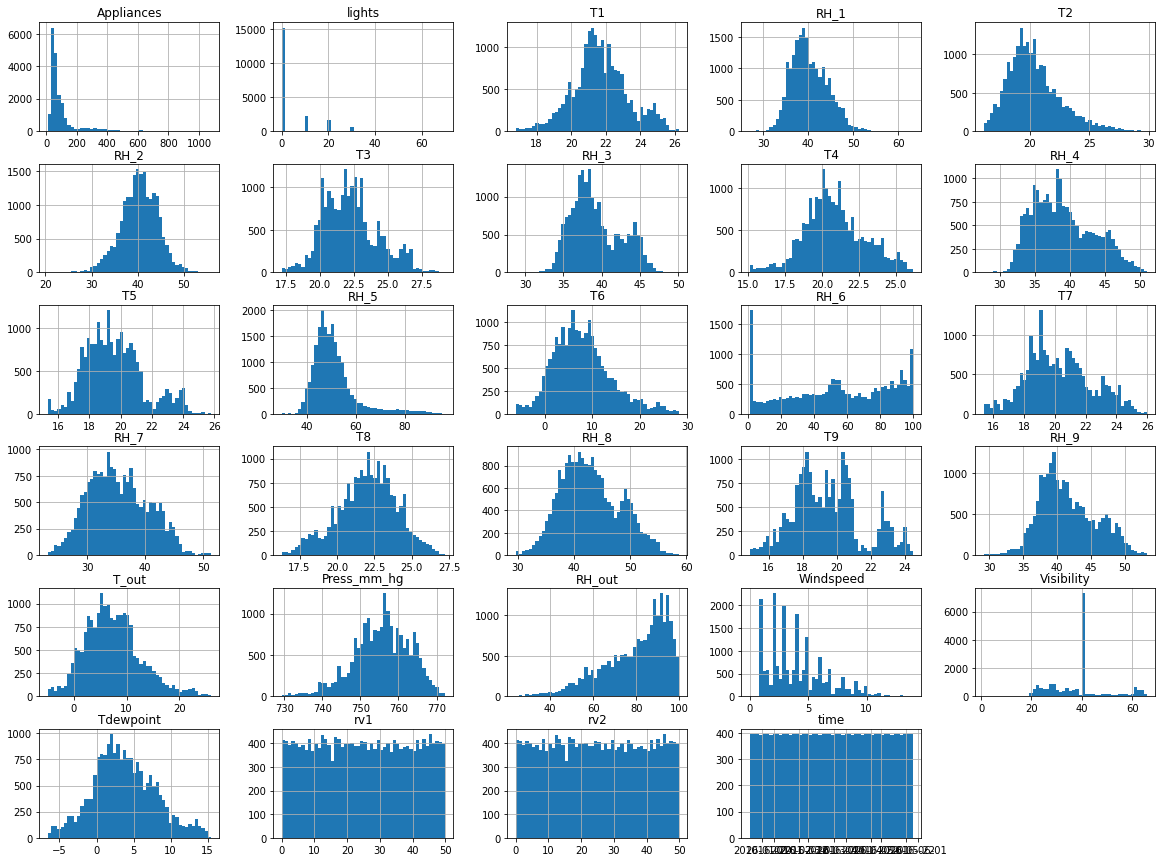

In [6]:
# Visualize the distribution of data
df.hist(bins=50, figsize=(20, 15))
plt.show()

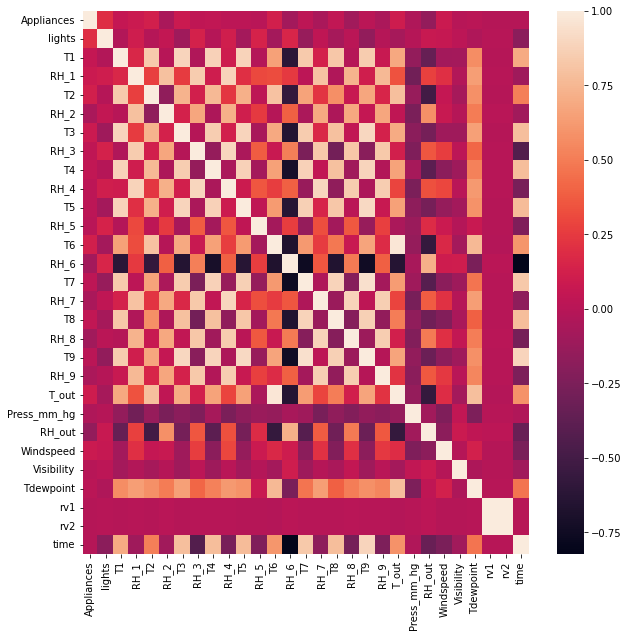

In [7]:
# Visualize correlation between variables
# Set up larger figure
fig, ax = plt.subplots(figsize=(10,10))

# Visualize correlation between variables after one-hot encoding
corr = df_processed.corr()
sns.heatmap(corr, annot=False, ax=ax)

In [8]:
# Create X features set and y outcome set
X = df_processed.drop(["Appliances"], axis=1)
y = df_processed["Appliances"]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

# Show VIF values
print(vif)

      VIF Factor     features
0   1.284959e+00       lights
1   1.967565e+01           T1
2   1.595940e+01         RH_1
3   2.879941e+01           T2
4   2.190108e+01         RH_2
5   1.002729e+01           T3
6   1.078694e+01         RH_3
7   9.832096e+00           T4
8   1.714468e+01         RH_4
9   1.050931e+01           T5
10  1.378022e+00         RH_5
11  3.341789e+01           T6
12  9.934766e+00         RH_6
13  1.752336e+01           T7
14  1.083316e+01         RH_7
15  8.050219e+00           T8
16  8.507420e+00         RH_8
17  2.856819e+01           T9
18  6.531557e+00         RH_9
19  1.480950e+02        T_out
20  1.418948e+00  Press_mm_hg
21  4.988285e+01       RH_out
22  1.595934e+00    Windspeed
23  1.041476e+00   Visibility
24  8.644756e+01    Tdewpoint
25  9.007199e+15          rv1
26  9.007199e+15          rv2
27  2.051311e+04         time


In [9]:
# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Initialize the model     
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Predict y values for the validation set
y_pred = lr.predict(X_val)


In [11]:
# Calculate model perfomance metrics for the validation set
# Calculate mean squared error
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

# Calculate R-squared score
r2 = r2_score(y_val, y_pred)
print("R-squared: ", r2)

Mean squared error:  8868.809205688203
Root mean squared error:  94.17435535053161
R-squared:  0.1664159497525597


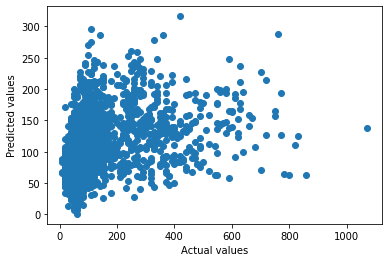

In [12]:
# Plot predicted values for the validation set
plt.scatter(y_val, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

In [30]:
# Re-run the model with PCA
# Perform PCA with 5 components
pca = PCA(n_components=5)
pca.fit(X)

# Get the transformed data
X = pca.transform(X)

# Print the variance explained by each component
print("Variance explained by principal components: ", pca.explained_variance_ratio_)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Initialize the model     
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Predict y values for the validation set
y_pred = lr.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

# Calculate root mean squared error
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

# Calculate R-squared score
r2 = r2_score(y_val, y_pred)
print("R-squared: ", r2)



Variance explained by principal components:  [0.45126097 0.32220606 0.09056971 0.0837618  0.05220147]
Mean squared error:  9949.80253380258
Root mean squared error:  99.74869690277954
R-squared:  0.06481281726414134


8593.60505700532


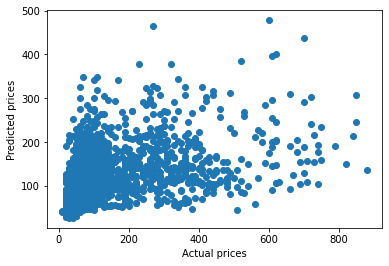

In [33]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
plt.scatter(y_test, y_pred)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.show()